## Basic Nipype

Author: Steffen Bollmann

## Output CPU information

In [2]:
%%bash
cat /proc/cpuinfo | grep 'vendor' | uniq
cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


# Demonstrating the module system in Python and Nipype

In [3]:
# we can use module to load fsl in a specific version
import module
await module.load('fsl/6.0.4')
await module.list()

['fsl/6.0.4']

In [4]:
from nipype.interfaces.fsl.base import Info
print(Info.version())
# if the FSL version is changed using module above, the kernel of the notebook needs to be restarted!

None


In [5]:
!bet


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

## Load afni and SPM as well

In [6]:
await module.load('afni/22.3.06')
await module.load('spm12/r7771')
await module.list()

['fsl/6.0.4', 'afni/22.3.06', 'spm12/r7771']

## download test data

In [7]:
%%bash
if [ -f ./sub-01_ses-01_7T_T1w_defaced.nii ]; then
    echo "nii Output file exists, not downloading or unpacking again"
else
    if [ ! -f ./sub-01_ses-01_7T_T1w_defaced.nii.gz  ]; then
        echo "nii.gz does not exist. So, it needs to be downloaded."
        osfURL="osfstorage/TOMCAT_DIB/sub-01/ses-01_7T/anat/sub-01_ses-01_7T_T1w_defaced.nii.gz"
        echo "downloading now ..."
        osf -p bt4ez fetch $osfURL ./sub-01_ses-01_7T_T1w_defaced.nii.gz
    fi

    if [  -f ./sub-01_ses-01_7T_T1w_defaced.nii.gz ]; then
        echo "nii.gz exists. So, it needs to be unpacked and deleted"
        echo "unpacking now ..."
        gunzip ./sub-01_ses-01_7T_T1w_defaced.nii.gz
    fi
fi

nii.gz does not exist. So, it needs to be downloaded.
downloading now ...


100%|██████████| 72.7M/72.7M [00:08<00:00, 8.99Mbytes/s]


nii.gz exists. So, it needs to be unpacked and deleted
unpacking now ...


In [8]:
%ls 

MRIQC.ipynb           bids_conversion.ipynb  sub-01_ses-01_7T_T1w_defaced.nii
PyBIDS.ipynb          nipype_full.ipynb
RISE_slideshow.ipynb  nipype_short.ipynb


## run nipype pipeline

In [9]:
%%capture
!pip install nibabel numpy scipy

In [10]:
from nipype.interfaces import fsl
from nipype.interfaces import afni

btr = fsl.BET()
btr.inputs.in_file = './sub-01_ses-01_7T_T1w_defaced.nii'
btr.inputs.frac = 0.4
btr.inputs.out_file = './sub-01_ses-01_7T_T1w_defaced_brain.nii'
res = btr.run() 

edge3 = afni.Edge3()
edge3.inputs.in_file = './sub-01_ses-01_7T_T1w_defaced.nii'
edge3.inputs.out_file = './sub-01_ses-01_7T_T1w_defaced_edges.nii'
edge3.inputs.datum = 'byte'
res = edge3.run()

250604-03:51:38,804 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250604-03:51:49,813 nipype.interface INFO:
	 stderr 2025-06-04T03:51:49.813256:++ 3dedge3: AFNI version=AFNI_22.3.06 (Nov 15 2022) [64-bit]
250604-03:51:49,815 nipype.interface INFO:
	 stderr 2025-06-04T03:51:49.815020:** AFNI converts NIFTI_datatype=4 (INT16) in file /home/jovyan/Git_repositories/example-notebooks/books/workflows/sub-01_ses-01_7T_T1w_defaced.nii to FLOAT32
250604-03:51:49,815 nipype.interface INFO:
	 stderr 2025-06-04T03:51:49.815020:     Warnings of this type will be muted for this session.
250604-03:51:49,815 nipype.interface INFO:
	 stderr 2025-06-04T03:51:49.815020:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
250604-03:51:49,823 nipype.interface INFO:
	 stderr 2025-06-04T03:51:49.823697:*+ WARNING:   If you are performing spatial transformations on an oblique dset,
250604-03:51:49,824 nipype.interface INFO:
	 stderr 20

In [11]:
%ls

MRIQC.ipynb            nipype_short.ipynb
PyBIDS.ipynb           sub-01_ses-01_7T_T1w_defaced.nii
RISE_slideshow.ipynb   sub-01_ses-01_7T_T1w_defaced_brain.nii.gz
bids_conversion.ipynb  sub-01_ses-01_7T_T1w_defaced_edges.nii
nipype_full.ipynb


In [12]:
# View 3D data
import matplotlib.pyplot as plt

def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
#   print('Matrix size: {}'.format(image_3d.shape))
  fig = plt.figure(figsize=(15, 4))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

def get_figure():
    """
    Returns figure and axis objects to plot on. 
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

In [13]:
import nibabel as nib
from matplotlib import transforms
from scipy import ndimage
import numpy as np

# load data
brain_full = nib.load('./sub-01_ses-01_7T_T1w_defaced.nii').get_fdata()
brain = nib.load('./sub-01_ses-01_7T_T1w_defaced_brain.nii.gz').get_fdata()
edges = nib.load('./sub-01_ses-01_7T_T1w_defaced_edges.nii').get_fdata()

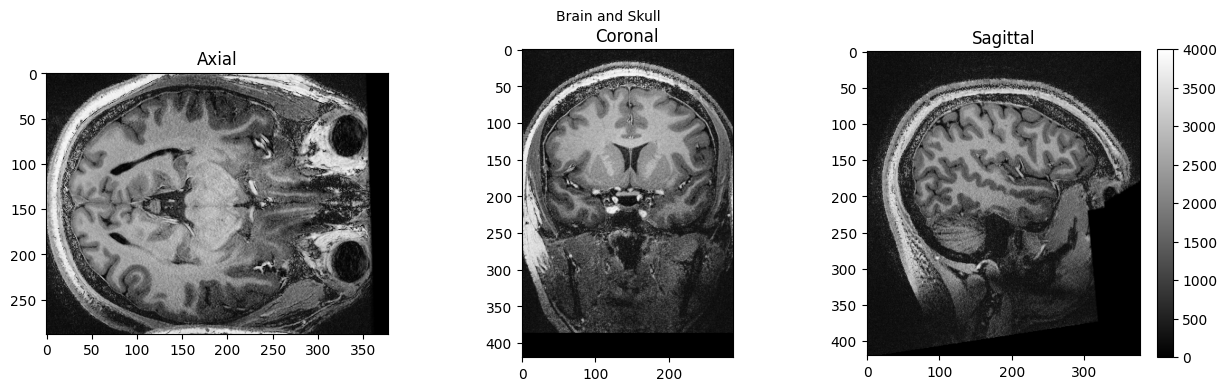

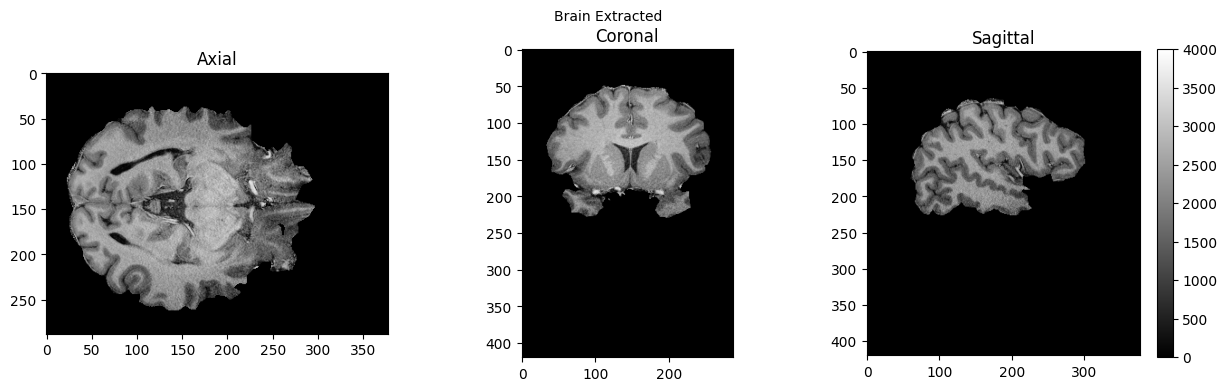

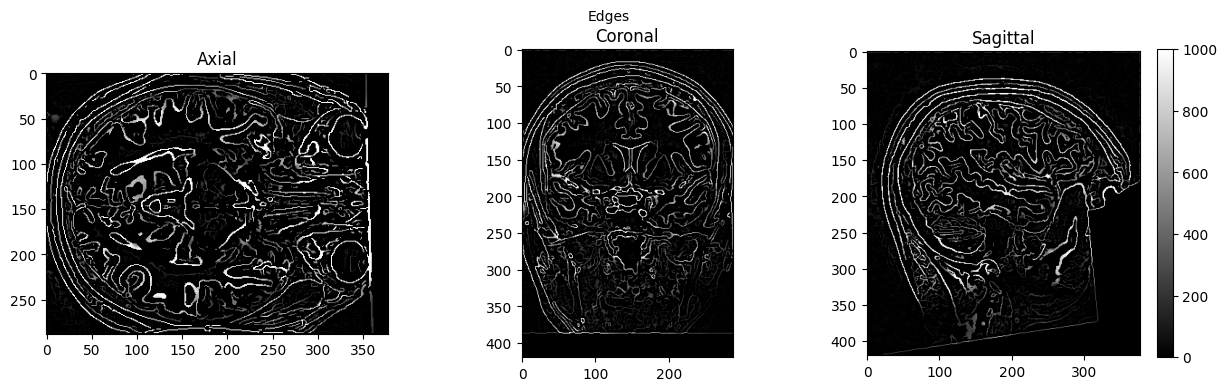

In [14]:
view_slices_3d(brain_full, slice_nbr=230, vmin=0, vmax=4000, title='Brain and Skull')
view_slices_3d(brain, slice_nbr=230, vmin=0, vmax=4000, title='Brain Extracted')
view_slices_3d(edges, slice_nbr=230, vmin=0, vmax=1000, title='Edges')

In [17]:
from ipyniivue import NiiVue

nv = NiiVue()
nv.load_volumes([{"path": "./sub-01_ses-01_7T_T1w_defaced_brain.nii.gz"}])
nv

NiiVue(height=300)

In [18]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/sub-01_ses-01_7T_T1w_defaced_brain.png')

SPM can also be used in such a workflow, but unfortunately, this will trigger a warning "stty: 'standard input': Inappropriate ioctl for device", which you can ignore (or help us to find out where it comes from):

In [19]:
import nipype.interfaces.spm as spm

norm12 = spm.Normalize12()
norm12.inputs.image_to_align = './sub-01_ses-01_7T_T1w_defaced.nii'
norm12.run()

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


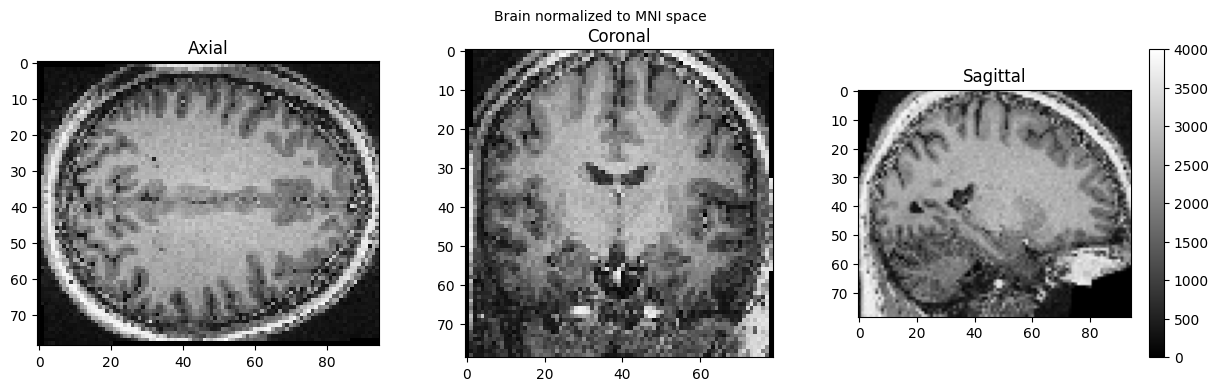

In [20]:
brain_full = nib.load('./wsub-01_ses-01_7T_T1w_defaced.nii').get_fdata()
view_slices_3d(brain_full, slice_nbr=50, vmin=0, vmax=4000, title='Brain normalized to MNI space')

In [21]:
nv = NiiVue()
nv.load_volumes([{"path": "./wsub-01_ses-01_7T_T1w_defaced.nii"}])
nv

NiiVue(height=300)

In [22]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/wsub-01_ses-01_7T_T1w_defaced.png')